<a href="https://colab.research.google.com/github/cpwan/citadel-summer-datathon-2021/blob/eda/spatial_temporal_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependency

In [ ]:
!pip install pysal -q
!pip install plotly==5.1.0 -q

     |████████████████████████████████| 2.4MB 7.2MB/s 
     |████████████████████████████████| 112kB 25.6MB/s 
     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 163kB 28.2MB/s 
     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 51kB 2.7MB/s 
     |████████████████████████████████| 215kB 12.9MB/s 
     |████████████████████████████████| 5.7MB 30.8MB/s 
     |████████████████████████████████| 71kB 6.2MB/s 
     |████████████████████████████████| 143kB 43.7MB/s 
     |████████████████████████████████| 235kB 43.1MB/s 
     |████████████████████████████████| 245kB 42.8MB/s 
     |████████████████████████████████| 56.1MB 46kB/s 
     |████████████████████████████████| 1.0MB 30.4MB/s 
     |████████████████████████████████| 2.0MB 28.5MB/s 
     |████████████████████████████████| 1.0MB 20.2MB/s 
     |████████████████████████████████| 19.3MB 1.5MB/s 
    

# Download data

In [ ]:
!gdown --id 1ecgxSTxCmhCvVTSFgUBRGVjyGf3rLREW -O dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1ecgxSTxCmhCvVTSFgUBRGVjyGf3rLREW
To: /content/dataset.zip
69.1MB [00:01, 37.3MB/s]


In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: Datasets/econ_state.csv  
  inflating: Datasets/demographics.csv  
  inflating: Datasets/venues.csv.gz  
  inflating: Datasets/real_estate.csv.gz  
  inflating: Datasets/listings.csv   
  inflating: Datasets/calendar.csv.gz  


In [ ]:
!gzip -dk Datasets/*.gz

In [ ]:
linksToGeoJson={
    'los-angeles':'http://data.insideairbnb.com/united-states/ca/los-angeles/2021-04-07/visualisations/neighbourhoods.geojson',
    "asheville":"http://data.insideairbnb.com/united-states/nc/asheville/2021-04-19/visualisations/neighbourhoods.geojson",
    "austin":"http://data.insideairbnb.com/united-states/tx/austin/2021-04-16/visualisations/neighbourhoods.geojson",
    "nashville":"http://data.insideairbnb.com/united-states/tn/nashville/2021-02-19/visualisations/neighbourhoods.geojson",
    "new-orleans":"http://data.insideairbnb.com/united-states/la/new-orleans/2021-04-10/visualisations/neighbourhoods.geojson"
}

In [ ]:
!mkdir geoJson
import urllib.request 
for (filename,url) in linksToGeoJson.items():
  print('Downloading', filename)
  urllib.request.urlretrieve(url, f'geoJson/{filename}.geojson')

In [ ]:
# merge multiple geojsons into one
!wget https://gist.githubusercontent.com/migurski/3759608/raw/7f49ed228f40d6384463ec10a96f54e0a26ad5a5/merge-geojsons.py
!touch geoJson/multiple-regions.geojson
!python merge-geojsons.py geoJson/asheville.geojson geoJson/los-angeles.geojson geoJson/new-orleans.geojson geoJson/austin.geojson geoJson/nashville.geojson geoJson/multiple-regions.geojson

--2021-07-15 12:35:25--  https://gist.githubusercontent.com/migurski/3759608/raw/7f49ed228f40d6384463ec10a96f54e0a26ad5a5/merge-geojsons.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1754 (1.7K) [text/plain]
Saving to: ‘merge-geojsons.py’

merge-geojsons.py   100%[===================>]   1.71K  --.-KB/s    in 0s      

2021-07-15 12:35:26 (24.2 MB/s) - ‘merge-geojsons.py’ saved [1754/1754]



# Load data

In [ ]:
# dsets: name of csv
# regions: the geo-region to look at, specified by the filename of the geojsons
dsets=['listings','calendar','demographics','econ_state','real_estate','venues']
regions=[*linksToGeoJson.keys()]+['multiple-regions']
regions

['los-angeles',
 'asheville',
 'austin',
 'nashville',
 'new-orleans',
 'multiple-regions']

In [ ]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

from re import sub
from decimal import Decimal

import json
from pathlib import Path

import plotly.express as px

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Preprocessing

In [ ]:
# helper function to convert dataframe to GeoDataFrame
def constructGDF(df):
  geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
  crs = {'init': 'epsg:4326'} 
  bl_gdf = GeoDataFrame(df, crs=crs, geometry=geometry)
  return bl_gdf

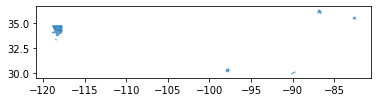

In [ ]:
dset='listings'
df_geo=pd.read_csv(f'./Datasets/{dset}.csv')
region='multiple-regions'
gdf = gpd.read_file(f'geoJson/{region}.geojson')
gdf.plot()

In [ ]:
region_gdf=constructGDF(df_geo)
sj_gdf = gpd.sjoin(gdf, region_gdf, how='inner', op='intersects', lsuffix='left', rsuffix='right')

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  


In [ ]:
linksToGeoJson.keys()

dict_keys(['los-angeles', 'asheville', 'austin', 'nashville', 'new-orleans'])

In [ ]:
df_loc=sj_gdf[['id','latitude','longitude','neighbourhood','metropolitan']].sort_values(['id'])
df_loc['metropolitan']=df_loc['metropolitan'].replace({'LA':'los-angeles', 'new_orleans':'new-orleans'})
df_loc.to_csv('Datasets/loc.csv',index=None) 
df_loc.head()

,id,latitude,longitude,neighbourhood,metropolitan
97,109,33.982095,-118.384935,Culver City,los-angeles
87,344,34.165616,-118.334582,Burbank,los-angeles
200,941,34.071556,-118.350786,Fairfax,los-angeles
381,1078,30.301231,-97.736736,78705,austin
364,2265,30.277500,-97.713975,78702,austin


# Debug

In [ ]:
# helper function to clean the dataset
def cleanPrice(df,col_name):
  def string2float(s):
    try:
      return Decimal(sub(r'[^\d.]', '', s))
    except:
      return s
  df[col_name]=df[col_name].apply(string2float).astype(float)
  return df
def cleanDate(df,period=None):
  df['date']=pd.to_datetime(df['date'])
  if period:
    df['date']=df.date.dt.to_period(period)
  return df

def cleanCategory(df,col_name,mapping):
  df[col_name]=df[col_name].replace(mapping)
  return df

In [ ]:
dset='loc'
df_loc=pd.read_csv(f'./Datasets/{dset}.csv')
df_loc.head()

,id,latitude,longitude,neighbourhood,metropolitan
0,109,33.982095,-118.384935,Culver City,los-angeles
1,344,34.165616,-118.334582,Burbank,los-angeles
2,941,34.071556,-118.350786,Fairfax,los-angeles
3,1078,30.301231,-97.736736,78705,austin
4,2265,30.277500,-97.713975,78702,austin


In [ ]:
dset='calendar'
df=pd.read_csv(f'./Datasets/{dset}.csv')
df.head()

,listing_id,date,available,price,metro_area
0,665257,2016-04-22,f,NaN,asheville
1,665257,2016-04-23,f,NaN,asheville
2,665257,2016-04-24,f,NaN,asheville
3,665257,2016-04-25,f,NaN,asheville
4,665257,2016-04-26,f,NaN,asheville


In [ ]:
df=cleanPrice(df,col_name='price')
df=cleanDate(df,period='M')
df=cleanCategory(df,col_name='available',mapping={'t':1,'f':0})


df_gp=df.groupby(['listing_id','date']).mean()
df_gp.to_csv('calendar_monthly.csv')
df_gp.head()

available  price
listing_id date                     
109        2017-05        0.0    NaN
           2017-06        0.0    NaN
           2017-07        0.0    NaN
           2017-08        0.0    NaN
           2017-09        0.0    NaN

In [ ]:
df_gp_flat=df_gp.reset_index().set_index('listing_id')
join_df=df_gp_flat.join(df_loc.set_index('id'))
join_df.head()

,date,available,price,latitude,longitude,neighbourhood,metropolitan
109,2017-05,0.0,NaN,33.982095,-118.384935,Culver City,los-angeles
109,2017-06,0.0,NaN,33.982095,-118.384935,Culver City,los-angeles
109,2017-07,0.0,NaN,33.982095,-118.384935,Culver City,los-angeles
109,2017-08,0.0,NaN,33.982095,-118.384935,Culver City,los-angeles
109,2017-09,0.0,NaN,33.982095,-118.384935,Culver City,los-angeles


In [ ]:
agg_df=join_df.groupby(['metropolitan','neighbourhood','date']).agg({'available':['count','mean'],'price':'mean'})
agg_df.columns=['number of listings','occupancy rate','mean price'] #rename columns
agg_df=agg_df.reset_index() # flatten the index
agg_df['date']=agg_df['date'].astype(str)

agg_df.to_csv('calendar_geo.csv',index=None)
agg_df.head()


,metropolitan,neighbourhood,date,number of listings,occupancy rate,mean price
0,asheville,28704,2016-04,30,0.488906,89.805714
1,asheville,28704,2016-05,30,0.672043,99.707694
2,asheville,28704,2016-06,30,0.717778,96.511084
3,asheville,28704,2016-07,30,0.693548,95.092548
4,asheville,28704,2016-08,30,0.753763,104.369899


In [ ]:
# helper function to plot the choropleth map given 
def plot_SpatialTemporal(df_toplot,counties,key,hover_keys,out_filename):
  fig = px.choropleth(df_toplot,geojson=counties,locations='neighbourhood',
                      featureidkey='properties.neighbourhood',
                      color=key,
                      color_continuous_scale="Viridis",
                      scope="usa",
                      range_color=[df_toplot[key].min(),df_toplot[key].max()],
                      animation_frame="date",    
                      hover_data=hover_keys,
                      )
  fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
  fig.update_geos(fitbounds="locations")
  # fig.show()
  fname=f"./plotly-st/{out_filename}.html"
  fig.write_html(fname) # hardcoded to convert `median_XXX` to `XXX`

In [ ]:
keys=['number of listings', 'occupancy rate', 'mean price']
for key in keys[1:]:
  for region in regions[:-1]:
    Path(f"./plotly-st/{dset}/{region}").mkdir(parents=True, exist_ok=True)
    print(f'Plotting {key} in {region}...')
    counties = json.load(open(f'geoJson/{region}.geojson'))
    df_toplot = agg_df[agg_df['metropolitan']==region]
    plot_SpatialTemporal(df_toplot,counties,key,keys,out_filename=f'{dset}/{region}/{key.replace(" ","-")}')

Plotting occupancy rate in los-angeles...
Plotting occupancy rate in asheville...
Plotting occupancy rate in austin...
Plotting occupancy rate in nashville...
Plotting occupancy rate in new-orleans...
Plotting mean price in los-angeles...
Plotting mean price in asheville...
Plotting mean price in austin...
Plotting mean price in nashville...
Plotting mean price in new-orleans...
